## Import 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from scipy import stats
import yaml
from astropy.coordinates import SkyCoord

from gammapy.data import DataStore
from regions import CircleSkyRegion
from gammapy.modeling import Fit
from gammapy.datasets import MapDataset
from gammapy.estimators import ExcessMapEstimator
from gammapy.modeling.models import Models, Model, SkyModel, FoVBackgroundModel
from gammapy.maps import MapAxis, WcsGeom, Map
from gammapy.modeling import Fit, Parameter, Parameters, Covariance


import warnings
from my_dataset_maps_19 import MapDatasetNuisance
warnings.filterwarnings('ignore')
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']



## Definitions 

In [18]:
def plot_residual_comparison(dataset1, dataset2, elist, radius = 1.0, ):
    print("Radius:", radius)
    fig, axs = plt.subplots(len(elist)*1,3 ,figsize =(15,len(elist)*5))
    if len(elist) ==1:
        axs = [axs]
    for i , e in enumerate (elist):
        print(e)
        residual1 = dataset1.residuals('diff/sqrt(model)').slice_by_idx(dict(energy=slice(e,e+1)))
        residual2 = dataset2.residuals('diff/sqrt(model)').slice_by_idx(dict(energy=slice(e,e+1)))
        print("residual1.data:", np.nanmax(residual1.data))
        vmax_ = np.nanmax(np.abs(residual1.smooth(radius).data))
        print("vmax_:", vmax_)   
        residual2.smooth(radius).plot(cmap = 'coolwarm', add_cbar = True,ax = axs[i][1],
                                                      vmax = vmax_, vmin = -vmax_)
        residual1.smooth(radius).plot(cmap = 'coolwarm', add_cbar = True,ax = axs[i][0],
                                                        vmax = vmax_, vmin = -vmax_)
        n, bins, patches = axs[i][2].hist(residual1.data.flatten(),bins = 70,
                           label = 'Standard \n $\mu=${:.2}, $\sigma=${:.4}'.format(
                           np.nanmean(residual1.data.flatten()),
                           np.nanstd(residual1.data.flatten())),
                                  color = default_colors[1], alpha = 0.5)
        axs[i][2].hist(residual2.data.flatten(),bins = bins,
                                 label = 'Standard $\cdot (1+N) $\n $\mu=${:.2}, $\sigma=${:.4}'.format(
                               np.nanmean(residual2.data.flatten()),
                               np.nanstd(residual2.data.flatten())),
                           color = default_colors[2], alpha = 0.5)



        axs[i][2].legend(fontsize = 14)
        axs[i][2].set_xlabel('Significance'); axs[i][2].set_yscale('log')
        axs[i][1].set_title('With Nui Par; \nSmoothing Radius:'+str(radius), fontsize = 14)
        ee = dataset1.geoms['geom'].axes[0]
        ee_start = ee.edges[e]
        ee_end = ee.edges[e+1]
        ee = f"[{ee_start.value:.2}:{ee_end.value:.2}] TeV"
        axs[i][0].set_title(ee ,fontsize = 14)
        

    plt.tight_layout()
    return fig



## Import of Datasets

In [3]:
source = "Crab"

In [4]:
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
# here the dataset with the fine binning is saved
#dataset_standard = MapDataset.read(f'{path}/{source}/stacked.fits')
# This is for now the binning of 0.08 deg
dataset_standard = MapDataset.read(f'{source}/stacked.fits')

models = Models.read(f'{source}/standard_model.yml')

with open(f'{source}/standard_bgmodel.yml', "r") as ymlfile:
    best_fit_bgmodel = yaml.load(ymlfile, Loader=yaml.FullLoader)
bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
print(best_fit_bgmodel)
bkg_model.parameters['norm'].value = best_fit_bgmodel['spectral']['parameters'][0]['value']
bkg_model.parameters['tilt'].value = best_fit_bgmodel['spectral']['parameters'][1]['value']
bkg_model.parameters['norm'].error = best_fit_bgmodel['spectral']['parameters'][0]['error']


models.append(bkg_model)
dataset_standard.models = models
dataset_standard.geoms['geom']

{'datasets_names': ['zqKn9jMc'], 'spectral': {'parameters': [{'error': 0.0016224536231473417, 'name': 'norm', 'value': 0.9965459485124857}, {'frozen': True, 'name': 'tilt', 'value': 0.0}, {'frozen': True, 'name': 'reference', 'unit': 'TeV', 'value': 1.0}], 'type': 'PowerLawNormSpectralModel'}, 'type': 'FoVBackgroundModel'}


WcsGeom

	axes       : ['lon', 'lat', 'energy']
	shape      : (150, 150, 24)
	ndim       : 3
	frame      : icrs
	projection : CAR
	center     : 83.6 deg, 22.0 deg
	width      : 12.0 deg x 12.0 deg
	wcs ref    : 83.6 deg, 22.0 deg

In [5]:
pathsource = f"{source}/"
dataset_N_10 = MapDatasetNuisance.read(f"{path}/{pathsource}nui_dataset.fits")
with open(pathsource+ 'nui_par.yml', "r") as ymlfile:
    nui_par = yaml.load(ymlfile, Loader=yaml.FullLoader)
dataset_N_10.N_parameters = Parameters.from_dict(nui_par )
with open(pathsource+ 'nui_model.yml', "r") as ymlfile:
    best_fit_model = yaml.load(ymlfile, Loader=yaml.FullLoader)
with open(pathsource+ 'nui_bgmodel.yml', "r") as ymlfile:
    best_fit_bgmodel = yaml.load(ymlfile, Loader=yaml.FullLoader)
bkg_model = FoVBackgroundModel(dataset_name=dataset_N_10.name)
bkg_model.parameters['norm'].value = best_fit_bgmodel['spectral']['parameters'][0]['value']
bkg_model.parameters['tilt'].value = best_fit_bgmodel['spectral']['parameters'][1]['value']
bkg_model.parameters['norm'].error = best_fit_bgmodel['spectral']['parameters'][0]['error']
bkg_model.parameters['tilt'].error = best_fit_bgmodel['spectral']['parameters'][1]['error']
models = Models.from_dict(best_fit_model )
models.append(bkg_model)
dataset_N_10.models =models

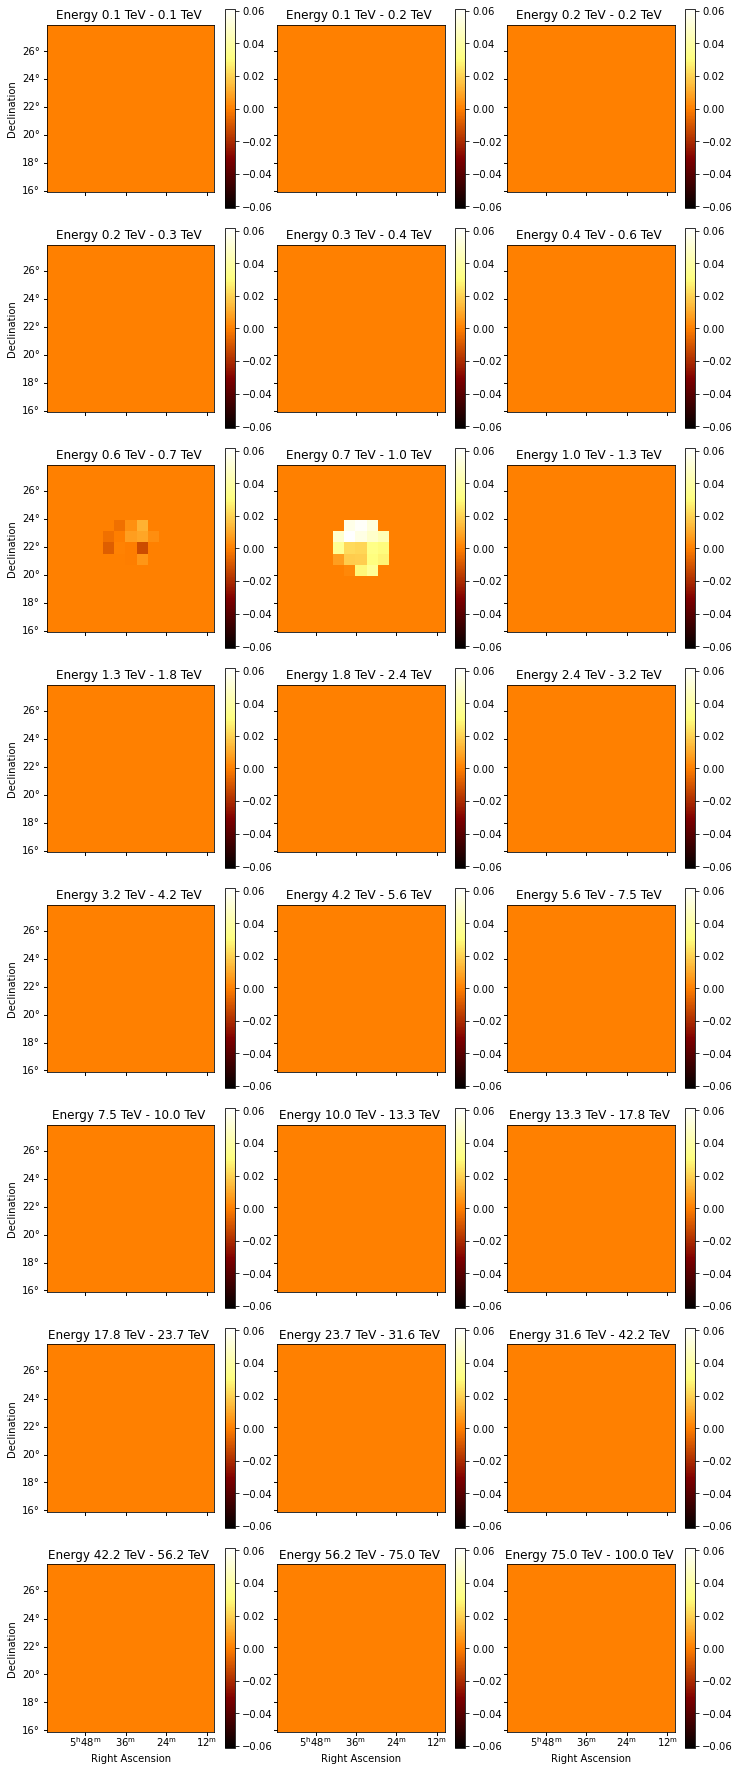

In [6]:
vmax = np.nanmax(np.abs(dataset_N_10.N_map().data))
dataset_N_10.N_map().plot_grid(add_cbar = True, vmax =vmax, vmin = -vmax);

1.2308969170301811


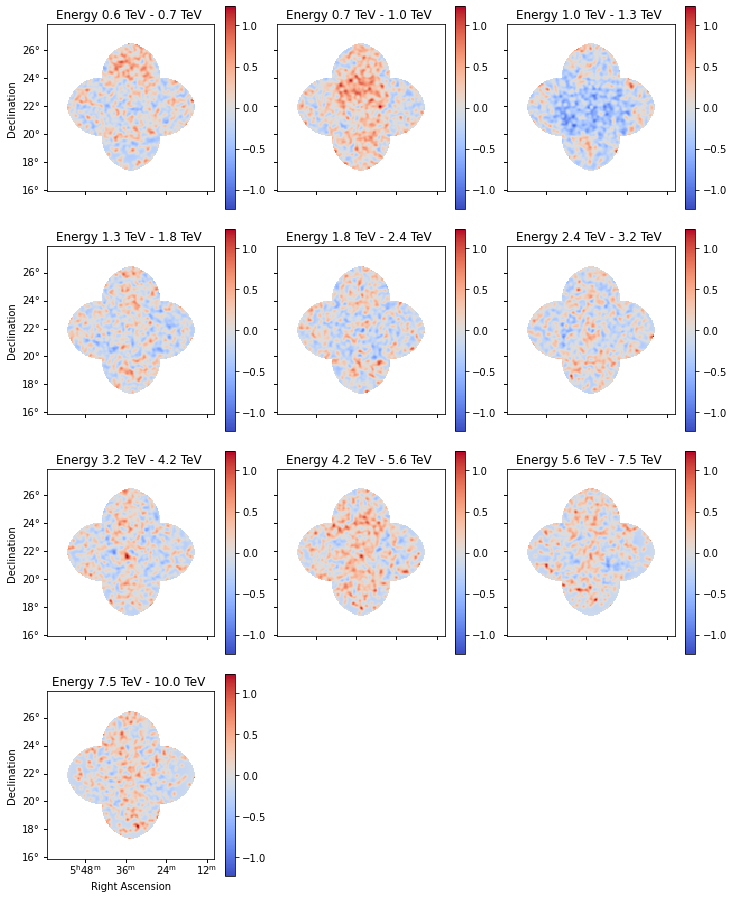

In [7]:
res_standard = (
    dataset_standard.residuals("diff/sqrt(model)")
    .slice_by_idx(dict(energy=slice(6, 16)))
    .smooth(0.1 * u.deg)
)
vmax = np.max(np.abs(np.nan_to_num(res_standard.data)))
print(vmax)
res_standard.plot_grid(add_cbar=1, vmax=vmax, vmin=-vmax, cmap="coolwarm");

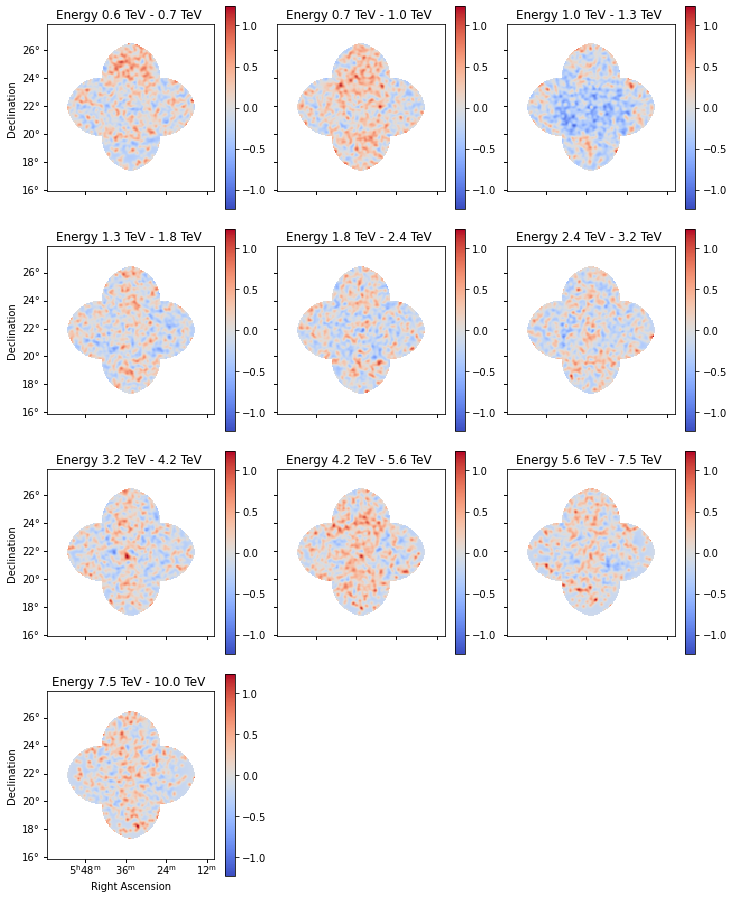

In [8]:
res_standard = (
    dataset_N_10.residuals("diff/sqrt(model)")
    .slice_by_idx(dict(energy=slice(6, 16)))
    .smooth(0.1 * u.deg)
)
res_standard.plot_grid(add_cbar=1, vmax=vmax, vmin=-vmax, cmap="coolwarm");

## Comparison of the Spatial Resiudal Maps

Radius: 0.1 deg
6
residual1.data: 7.38039049350974
vmax_: 0.9687032843003298
7
residual1.data: 8.739826550145247
vmax_: 1.2308969170301811


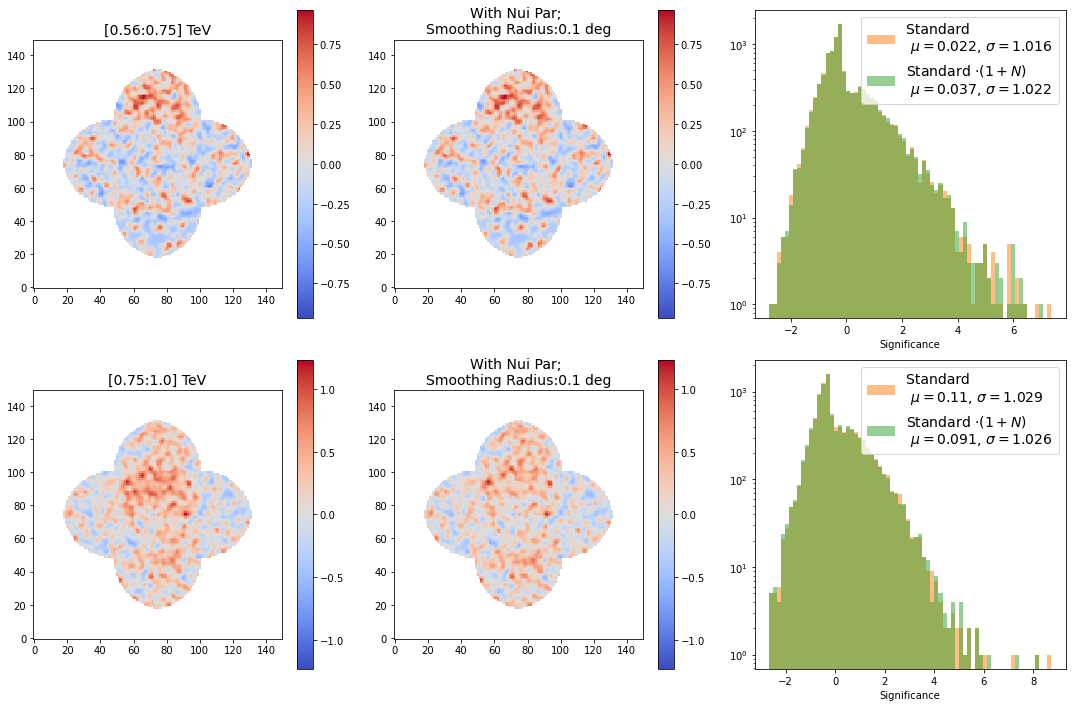

In [19]:
ebins = [6,7]
fig = plot_residual_comparison(dataset_standard, dataset_N_10,ebins , radius = 0.1 *u.deg)

## Comparison of the Best Fit Model Parameters

In [15]:
print(" with nuisance")
print("(without nuisance)")
for p_N, p_stand in zip(dataset_N_10.models.parameters.free_parameters,
                        dataset_standard.models.parameters.free_parameters ):
    print()
    print('='*5)
    print(p_N.name, p_stand.name)
    print('-'*5)
    print(' {:.4}  pm {:.3}'.format(p_N.value, float(p_N.error)) )    
    print('({:.4}  pm {:.3})'.format(p_stand.value, float(p_stand.error)) )

print("nuisance: {:.4} std: {:.4}".format(np.mean(dataset_N_10.N_parameters.value)
                                   , np.std(dataset_N_10.N_parameters.value)))

 with nuisance
(without nuisance)

=====
amplitude amplitude
-----
 3.7e-11  pm 1.47e-13
(3.698e-11  pm 2.83e-13)

=====
alpha alpha
-----
 2.512  pm 0.013
(2.513  pm 0.0183)

=====
beta beta
-----
 0.1037  pm 0.00126
(0.1032  pm 0.00912)

=====
lon_0 lon_0
-----
 83.63  pm 0.13
(83.63  pm 0.000635)

=====
lat_0 lat_0
-----
 22.02  pm 0.147
(22.02  pm 0.000873)

=====
sigma sigma
-----
 0.01922  pm 0.000144
(0.01917  pm 0.00427)

=====
norm norm
-----
 0.9869  pm 0.0138
(0.9965  pm 0.00162)
nuisance: 0.001117 std: 0.006839


In [16]:
sysamplitude_percentage = np.loadtxt((f'{path}/{source}/sysamplitude_percentage.txt'))
# Convert to %:
sysamplitude_percentage /= 100


0 6
1 7


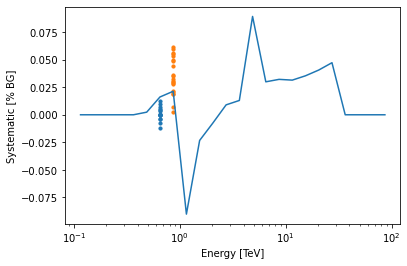

In [20]:
eaxis = dataset_N_10.geoms['geom'].axes[0].center.value
amount = dataset_N_10.geoms['geom_down'].data_shape[1]**2
mean_N_pars = []
max_N_pars = []
min_N_pars = []

for i, e in enumerate(ebins):
    print(i,e)
    Ns = [d if np.abs(d)>0 else np.nan for d in dataset_N_10.N_parameters.value[i*amount:(i+1)*amount] ]
    for N in Ns:
        plt.scatter(eaxis[e], [N], color = default_colors[i], s=10)
plt.plot(eaxis,sysamplitude_percentage, label = "Expected Systematic")
plt.ylabel('Systematic [% BG]')
plt.xlabel('Energy [TeV]')
plt.xscale('log')